# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.utils import shuffle


In [5]:
data = pd.read_csv('database/Churn.csv')

In [6]:
data.shape

(10000, 14)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Исходя из первого просмотра данных видны пропуски в Tenure, и заполнять их просто нулевыми значениями будет не особо правильно, поэтому попробую сначала заменить медианным значением, и посчитать score, и посмотрим какой score будет со средним значением. Так же я бы удалил RowNumber, CustomerId, Surname так как эти значения не будут играть роли в обучении.

In [8]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Удаление ненужных столбцов

In [10]:
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Заполнение пропусков медианным значением

In [11]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype('int64')

Перед тем как разделять выборки я хочу закодировать категориальные признаки. Буду делать по one-hot encoding

In [12]:
data_ohe = pd.get_dummies(data, drop_first=True)

Разделение выборок на тренировочную, тестовую, и валидационную

In [13]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=345)
valid_features, test_features, valid_target, test_target = train_test_split(valid_features, valid_target, test_size=0.5, 
                                                                              random_state=345 )
print(train_features.shape, valid_features.shape, test_features.shape)
print(train_target.shape, valid_target.shape, test_target.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Масштабирование параметров с помощью StandardScaler

In [14]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(train_features[numeric])
train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

In [15]:
test_features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7692,-0.170629,3.323092,-0.005976,0.527990,1,1,0,-1.577718,1,0,1
4924,1.462115,-0.283033,-0.005976,0.637921,2,0,0,-1.720455,1,0,1
4808,-0.077624,-0.567728,-0.005976,0.993225,1,1,1,1.462136,0,0,0
6863,-0.893996,-1.421810,0.356186,1.182735,1,1,1,0.921486,0,1,0
539,0.976426,-1.042218,-1.454621,0.563054,1,1,0,-0.478543,1,0,0


## Исследование задачи

0    7963
1    2037
Name: Exited, dtype: int64

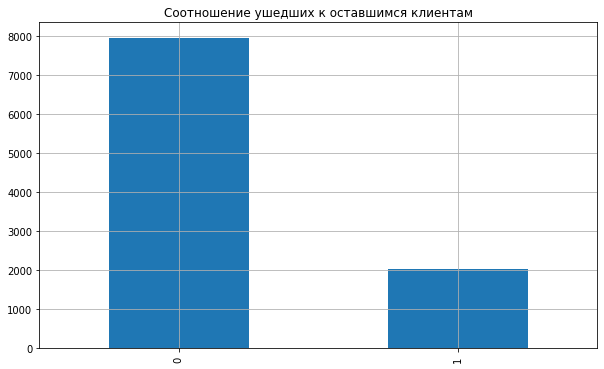

In [16]:
data['Exited'].value_counts().plot(kind='bar', grid=True,figsize=(10,6),title='Соотношение ушедших к оставшимся клиентам')
data['Exited'].value_counts()

Исходя из данных имеется дисбаланс классов. 1:4 в пользу оставшихся клиентов. Это может привести модель к склонению в распространённый вариант ответа.

Тестирование на дереве решений

In [17]:
model = DecisionTreeClassifier(random_state=345)
model.fit(train_features, train_target)
predicted_valid = model.predict(valid_features)

accuracy_valid = accuracy_score(predicted_valid, valid_target)

accuracy_valid 

0.7885

Проверка на адекватность модели

In [18]:
target_pred_constant = pd.Series([0]*len(valid_target))

print(accuracy_score(predicted_valid, target_pred_constant)) 

0.795


Матрица ошибок, плотность, точность, F1 score, roc_auc

In [19]:
print('матрица ошибок:', confusion_matrix(predicted_valid, valid_target))
print('Плотность:', recall_score(valid_target, predicted_valid))
print('Точность:',precision_score(valid_target, predicted_valid))
print('F1:', f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC-AUC", roc_auc_score(valid_target, probabilities_valid))

матрица ошибок: [[1384  206]
 [ 217  193]]
Плотность: 0.48370927318295737
Точность: 0.47073170731707314
F1: 0.47713226205191595
ROC-AUC 0.6740844929312663


Подбор гипперпараметров для дерева решений

In [20]:
f1_best = 0
depth_best = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=345, max_depth=depth)
    model.fit(train_features, train_target)
    prediction = model.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1>f1_best:
            f1_best=f1
            depth_best=depth
print('Max depth', depth_best,'F1-score', f1_best)

Max depth 6 F1-score 0.5448613376835236


Посмотрим на оценку accuracy, precision, recall, F1, AUC-ROC на полученных гиперпараметрах

In [21]:
model = DecisionTreeClassifier(random_state=345, max_depth=5)
model.fit(train_features, train_target)
prediction = model.predict(valid_features)
print('Accuracy', accuracy_score(valid_target, prediction))
print('Precision', precision_score(valid_target, prediction))
print('Recall', recall_score(valid_target, prediction))
print('F1', f1_score(valid_target, prediction))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

Accuracy 0.8595
Precision 0.8511904761904762
Recall 0.3583959899749373
F1 0.5044091710758377
ROC_AUC 0.8321655168527189


## Борьба с дисбалансом

Попробуем несколько способов борьбы с дисбалансом, а точнее взвешивание классов, уменьшение и увелечение выборки.

**Баланс классов для логистической регрессии**

In [22]:
model = LogisticRegression(random_state=345, solver='liblinear', class_weight='balanced')
model.fit(train_features, train_target)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.48220640569395024
ROC_AUC 0.7634232364170888


**Баланс классов для дерева решений**

In [23]:
model = DecisionTreeClassifier(random_state=345, class_weight='balanced')
model.fit(train_features, train_target)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.5038560411311054
ROC_AUC 0.6884622549503051


**Баланс классов с случайным лесом**

In [24]:
model = RandomForestClassifier(random_state=345, class_weight='balanced')
model.fit(train_features, train_target)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.5602503912363066
ROC_AUC 0.8483223987514069


**Увеличение выборки**

Функция для увеличения выборки

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train_features, train_target, 10)

In [26]:
features_upsampled.shape

(16935, 11)

Баланс классов

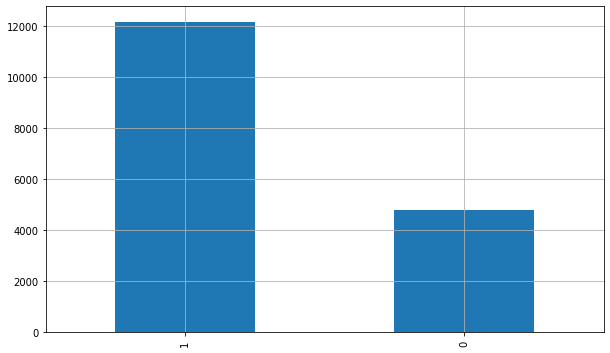

In [27]:
target_upsampled.value_counts().plot(kind='bar', grid=True,figsize=(10,6));

**Увеличенная выборка на дереве решений**

In [28]:
model = DecisionTreeClassifier(random_state=345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.502577319587629
ROC_AUC 0.6875214269277191


**Увеличенная выборка для случайного леса**

In [29]:
model = RandomForestClassifier(random_state=345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.5926928281461434
ROC_AUC 0.8384343118884031


**Увеличенная выборка для логистической регрессии**

In [30]:
model = LogisticRegression(random_state=345,  solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.40021990104453
ROC_AUC 0.7646646284668573


**Уменьшение выборки**

Функция для уменьшении выборки

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(train_features, train_target, 0.3)

In [32]:
print(features_downsampled.shape)

(2651, 11)


Визуализация распределения классов

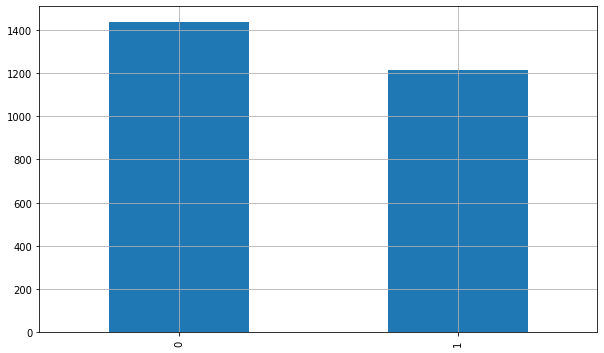

In [33]:
target_downsampled.value_counts().plot(kind='bar', grid=True,figsize=(10,6));

**Уменьшенная выборка для дерева решений**

In [34]:
model = DecisionTreeClassifier(random_state=345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.4658493870402803
ROC_AUC 0.6843639392046637


**Уменьшенная выборка для случайного леса**

In [35]:
model = RandomForestClassifier(random_state=345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.591002044989775
ROC_AUC 0.8444479405885106


**Уменьшенная выборка для логистической регрессии**

In [36]:
model = LogisticRegression(random_state=345,  solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(valid_features)
print('F1:',f1_score(valid_target, predicted_valid))
probabilities_valid = model.predict_proba(valid_features)[:, 1]
print("ROC_AUC", roc_auc_score(valid_target, probabilities_valid))

F1: 0.49375600384245927
ROC_AUC 0.7602344399412021


По итогу лучший результат f1 получается у уменьшенной выборки, и roc_auc так же увеличивается.

## Тестирование модели

Итак выборку получили, теперь попробую разные модели и поиск гипперпараментров

**Подбор модели для дерева решений и результат на тестовой выборке**

In [37]:
f1_best = 0
depth_best = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(valid_features)
    f1 = f1_score(valid_target , prediction)
    if f1 > f1_best:
            f1_best = f1
            depth_best = depth
print('Max depth', depth_best,'F1-score', f1_best)

Max depth 7 F1-score 0.5636363636363637


In [38]:
model = DecisionTreeClassifier(max_depth=7, random_state=345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(test_features)
print('F1:',f1_score(test_target , predicted_valid))
probabilities_valid = model.predict_proba(test_features)[:, 1]
print("ROC_AUC", roc_auc_score(test_target , probabilities_valid))

F1: 0.5826001955034213
ROC_AUC 0.8125536861893261


**Подбор модели для леса и результат на тестовой выборке**

In [39]:
f1_best = 0
estim_best = 0
depth_best = 0

for estim in range (10, 100, 5):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=345)
        model.fit(features_downsampled, target_downsampled)
        prediction = model.predict(valid_features)
        f1 = f1_score(valid_target , prediction)
        if f1>f1_best:
            f1_best=f1
            estim_best=estim
            depth_best=depth      
print('n_estimators =', estim_best, 'Max depth', depth_best, 'F1-score', f1_best)

n_estimators = 55 Max depth 8 F1-score 0.5975359342915811


In [40]:
model = RandomForestClassifier(max_depth=8, n_estimators=55, random_state=345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(test_features)
print('F1:',f1_score(test_target , predicted_valid))
probabilities_valid = model.predict_proba(test_features)[:, 1]
print("ROC_AUC", roc_auc_score(test_target, probabilities_valid))

F1: 0.6068548387096773
ROC_AUC 0.8594377510040161


Логистическая регрессия

In [41]:
model = LogisticRegression(random_state=345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(test_features)
print('F1:',f1_score(test_target , predicted_valid))
probabilities_valid = model.predict_proba(test_features)[:, 1]
print("ROC_AUC", roc_auc_score(test_target , probabilities_valid))

F1: 0.5245597775718257
ROC_AUC 0.7819812283849845


## Вывод

По итогу поиска лучшей модели пришел к выводу, что случайный лес на уменьшенной выборке показывает лучший результат

In [42]:
model = RandomForestClassifier(max_depth=8, n_estimators=55, random_state=345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(test_features)
print('F1:',f1_score(test_target , predicted_valid))
probabilities_valid = model.predict_proba(test_features)[:, 1]
print("ROC_AUC", roc_auc_score(test_target, probabilities_valid))

F1: 0.6068548387096773
ROC_AUC 0.8594377510040161
